In [7]:
import numpy as np
import torch
import torch.nn.functional as F
from data_visualisation import plot_single

In [8]:
#load the data
dataLR_dict = torch.load("serialized_data/dataLR.pt")
dataHR_dict = torch.load("serialized_data/dataHR.pt")

dataLR_raw = dataLR_dict["data"]
dataHR_raw = dataHR_dict["data"]

/tmp/ipykernel_35263/3307961193.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataLR_dict = torch.load("serialized_data/dataLR.pt")
/tmp/ipykernel_35263/3307961193.py:

In [9]:
import sys
sys.path.append('../downscaling_module')

In [10]:
import torch
from data_visualisation import plot_single, plot_bilinear_interpolation
from downscaling_module.data.datasets import ConvLSTMDataset

In [11]:
from downscaling_module.data.transforms import transforms
dataset = ConvLSTMDataset(dataLR_raw, dataHR_raw, transform=transforms)

Transforming with cutSequence
Transforming with bilinearInterpolation
Before interpolation:
LR: torch.Size([14, 500, 2, 1, 50]) HR: torch.Size([14, 500, 2, 5, 250])
Reshaped LR: torch.Size([7000, 2, 1, 50])
HR: torch.Size([14, 500, 2, 5, 250])
After interpolation:
LR resized: torch.Size([14, 500, 2, 5, 250]) HR: torch.Size([14, 500, 2, 5, 250])
Transforming with min_max_scale


In [12]:
dataLR, dataHR = dataset[:]
print(dataLR.shape, dataHR.shape)

# #reshape data
# dataLR_reshaped = dataLR.reshape(dataLR.shape[0]*dataLR.shape[1]*dataLR.shape[2], dataLR.shape[3], dataLR.shape[4])
# dataHR_reshaped = dataHR.reshape(dataHR.shape[0]*dataHR.shape[1]*dataHR.shape[2], dataHR.shape[3], dataHR.shape[4])

dataLR_reshaped_keep_time = dataLR.reshape(dataLR.shape[0], dataLR.shape[1]*dataLR.shape[2], dataLR.shape[3], dataLR.shape[4])
dataHR_reshaped_keep_time = dataHR.reshape(dataHR.shape[0], dataHR.shape[1]*dataHR.shape[2], dataHR.shape[3], dataHR.shape[4])

# dataLR_reshaped_B_C_H_W = dataLR.reshape(dataLR.shape[0]*dataLR.shape[1], dataLR.shape[2], dataLR.shape[3], dataLR.shape[4])
# dataHR_reshaped_B_C_H_W = dataHR.reshape(dataHR.shape[0]*dataHR.shape[1], dataHR.shape[2], dataHR.shape[3], dataHR.shape[4]

torch.Size([700, 10, 2, 5, 250]) torch.Size([700, 10, 2, 5, 250])


In [13]:
torch.min(dataLR), torch.max(dataLR), torch.min(dataHR), torch.max(dataHR)

(tensor(-0.5000), tensor(0.5000), tensor(-0.5000), tensor(0.5000))

In [11]:
import ignite
from ignite.engine import Engine, Events
from ignite.metrics import SSIM

ssim_metric = SSIM(data_range=1.0, kernel_size=9, sigma=1.5)

def evaluate(engine, batch):
    y_pred, y = batch
    return y_pred, y

evaluator = Engine(evaluate)

ssim_metric.attach(evaluator, "ssim")

mse = torch.nn.MSELoss()


In [12]:
ssim_scores = []
mse_scores = []
for i in range(dataHR.shape[0]):
    evaluator.run([[dataLR_reshaped_keep_time[i].unsqueeze(0), dataHR_reshaped_keep_time[i].unsqueeze(0)]])
    print(f"SSIM score for simulation {i} : {evaluator.state.metrics['ssim']:.2e}")
    print(f"MSE score for simulation {i} : {mse(dataLR_reshaped_keep_time[i], dataHR_reshaped_keep_time[i]).item():.2e}")
    ssim_scores.append(1 - evaluator.state.metrics['ssim'])
    mse_scores.append(mse(dataLR_reshaped_keep_time[i], dataHR_reshaped_keep_time[i]).item())

SSIM score for simulation 0 : 1.00e+00
MSE score for simulation 0 : 2.63e-06
SSIM score for simulation 1 : 1.00e+00
MSE score for simulation 1 : 3.15e-06
SSIM score for simulation 2 : 1.00e+00
MSE score for simulation 2 : 3.47e-06
SSIM score for simulation 3 : 1.00e+00
MSE score for simulation 3 : 3.73e-06
SSIM score for simulation 4 : 1.00e+00
MSE score for simulation 4 : 3.98e-06
SSIM score for simulation 5 : 1.00e+00
MSE score for simulation 5 : 3.86e-06
SSIM score for simulation 6 : 1.00e+00
MSE score for simulation 6 : 4.04e-06
SSIM score for simulation 7 : 9.99e-01
MSE score for simulation 7 : 4.65e-06
SSIM score for simulation 8 : 9.99e-01
MSE score for simulation 8 : 5.75e-06
SSIM score for simulation 9 : 9.99e-01
MSE score for simulation 9 : 6.84e-06
SSIM score for simulation 10 : 9.98e-01
MSE score for simulation 10 : 8.02e-06
SSIM score for simulation 11 : 9.98e-01
MSE score for simulation 11 : 1.03e-05
SSIM score for simulation 12 : 9.97e-01
MSE score for simulation 12 : 1.

In [15]:
mse_scores[49]

0.00012076379061909392

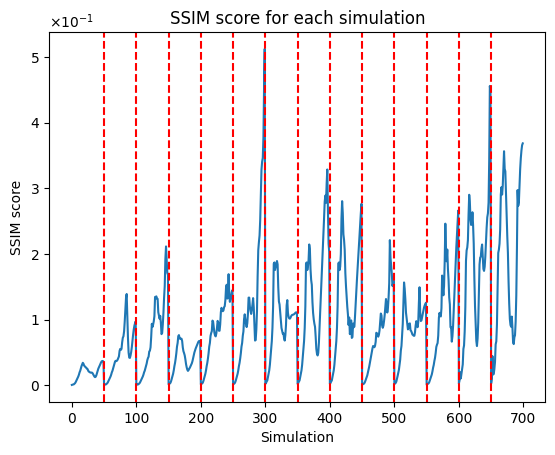

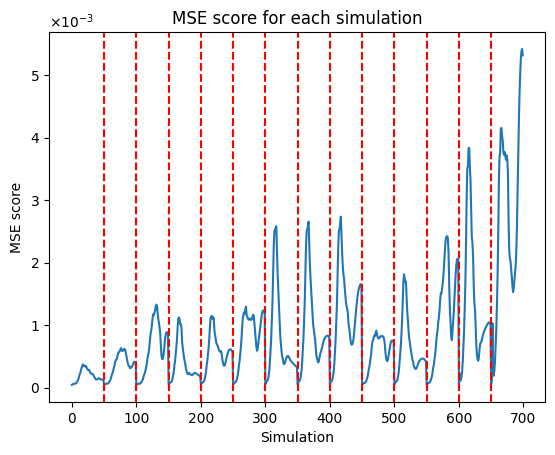

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plot SSIM scores
plt.figure()
plt.plot(ssim_scores)
plt.xlabel("Simulation")
plt.ylabel("SSIM score")
plt.title("SSIM score for each simulation")
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#plot a vertical line every 50 simulations
for i in range(1, 14):
    plt.axvline(x=i*50, color="red", linestyle="--")

plt.show()

# Plot MSE scores
plt.figure()
plt.plot(mse_scores)
plt.xlabel("Simulation")
plt.ylabel("MSE score")
plt.title("MSE score for each simulation")
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#plot a vertical line every 50 simulations
for i in range(1, 14):
    plt.axvline(x=i*50, color="red", linestyle="--")
    
plt.show()

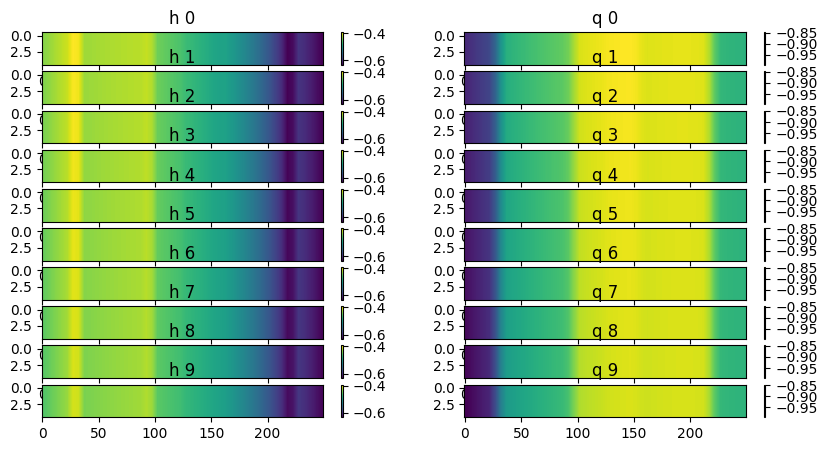

In [13]:
from data_visualisation import plot_batch
plot_batch(dataLR[49], 0, 9, 1)